# Curso de manejo de datos faltantes: Imputación

## Configuración del ambiente de trabajo

### Importar librerías

In [13]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar funciones personalizadas

In [14]:
%run ../context/0_pandas-missing-extension.ipynb

### Configurar el aspecto general de las gráficas del proyecto

In [15]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

### El problema de trabajar con valores faltantes

In [16]:
aq_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type = 'snake'
    )
    .add_column('year', 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by = 'date')
    .set_index('date')
)

aq_df

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [17]:
(
    smf.ols(
        formula='temp ~ ozone', 
        data = aq_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Tue, 03 Oct 2023",Prob (F-statistic):,2.93e-18
Time:,15:26:02,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [18]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r', 
        data = aq_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Tue, 03 Oct 2023",Prob (F-statistic):,1.47e-16
Time:,15:26:02,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


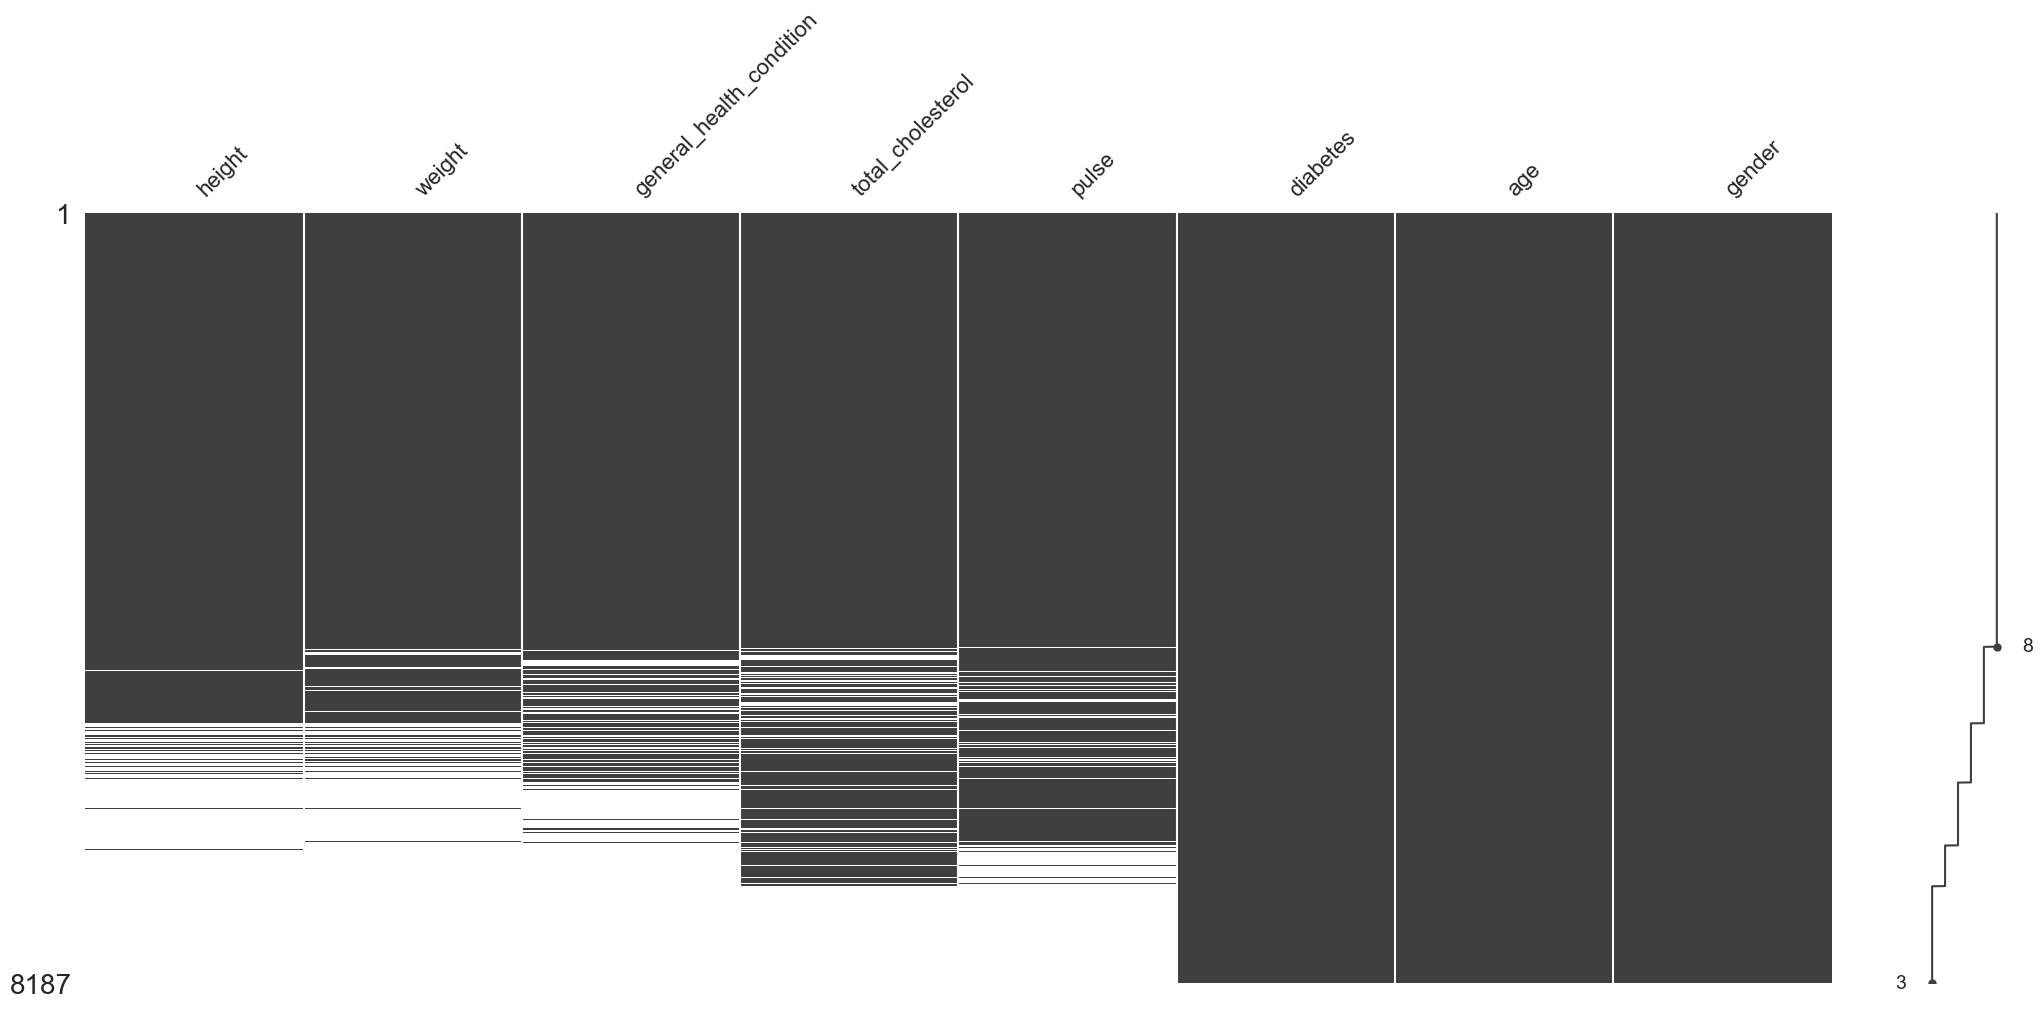

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


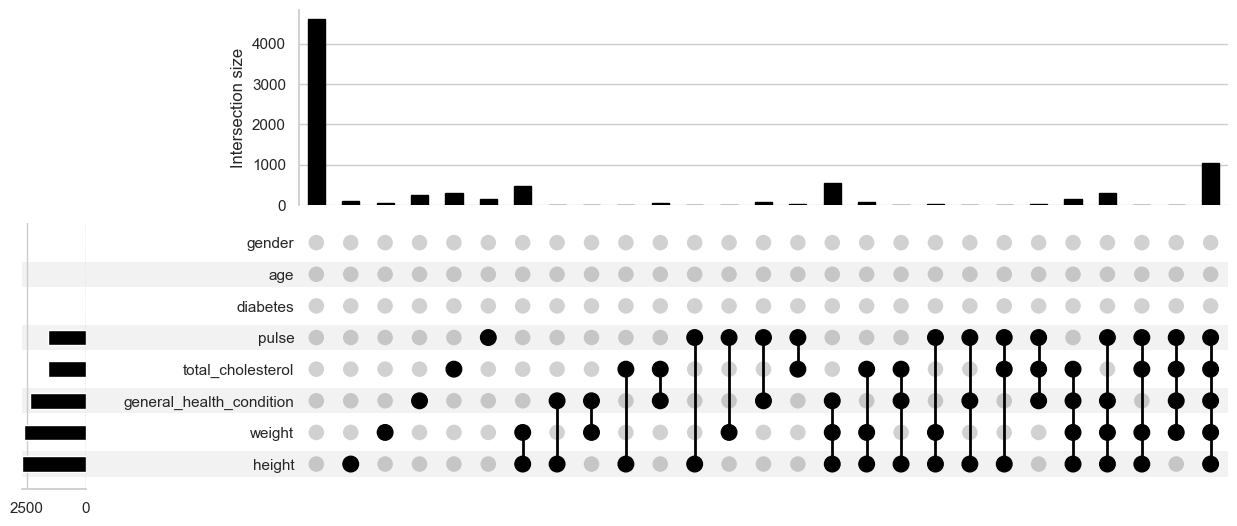

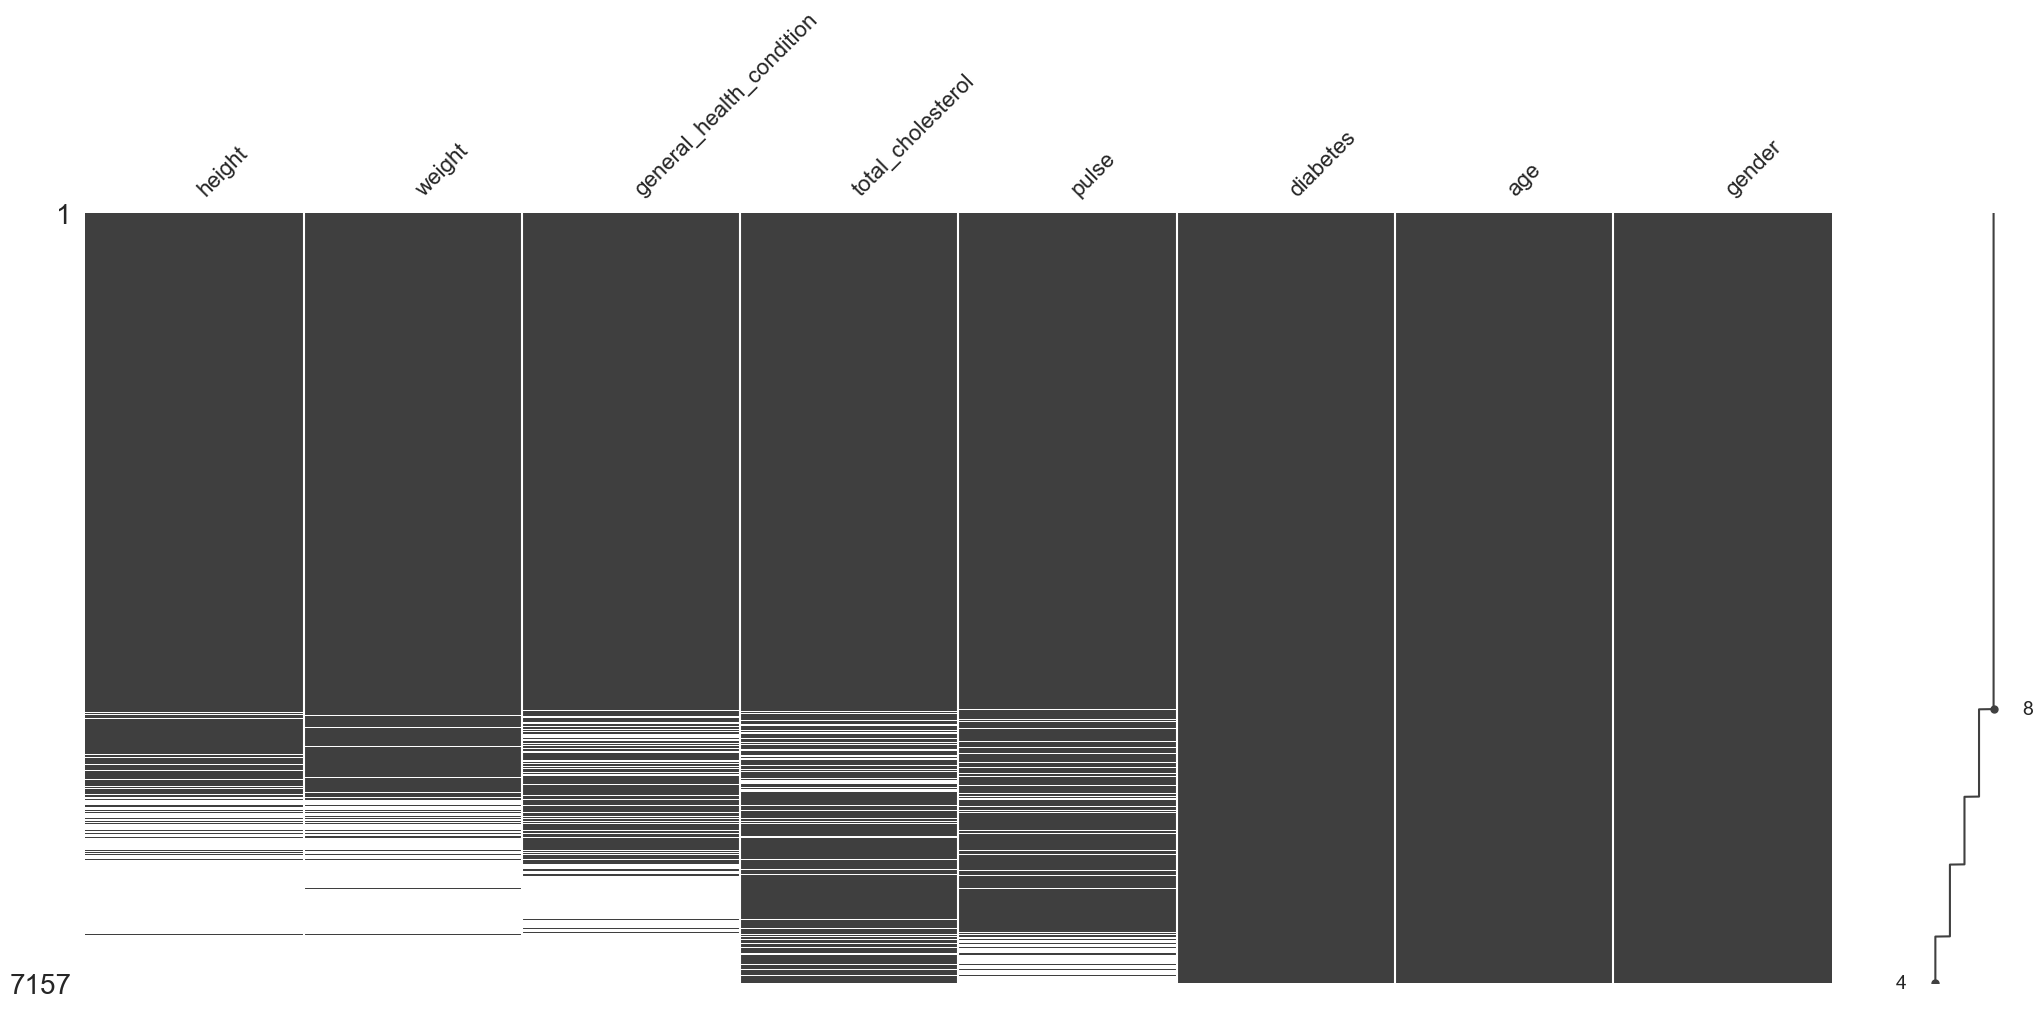

In [19]:
%run ../context/4_download-data-and-load-it.ipynb

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [20]:
nhanes_df.reset_index(inplace=True)
nhanes_df

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...,...
7152,102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
7153,102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
7154,102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female
7155,102955.0,NaN,NaN,Very good,150.0,74.0,0,14.0,Female


In [27]:
female_weight, male_weight = (
    nhanes_df
    .select_columns('gender', 'weight')
    .transform_column(
        'weight',
        # El valor de peso es faltante? 
        lambda x : x.isna(),
        # Para que regrese una serie
        elementwise = False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df : (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

# Haciendo una prueba estadistica para establecer si existe o no, una presencia o asuencia de valores de peso 
# ¿Existe una diferencia entre la presencia o ausencia de valores de mediciòn de peso?
# Si el pvalor es mayor a 0.05, no podemos aceptar ni rechazar la hipotesis nula de que exista una diferencia 
# El pvalor = 0.71, no podriamos rechazar nuestra hipotesis nula, es decir, no podemos decir que existe una diferecia entre las personas que tienen valores faltantes
# Con esto se podria decir que nuestros valores no estan perdidos al azar, al menos en las categorias 'female' y 'male'
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight, 
    alternative = 'two-sided'
)

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

In [25]:
female_weight

0       False
3       False
7       False
12       True
13      False
        ...  
7145     True
7146    False
7151    False
7154    False
7155     True
Name: weight, Length: 3665, dtype: bool

In [26]:
male_weight

1       False
2        True
4       False
5       False
6       False
        ...  
7149    False
7150    False
7152    False
7153    False
7156    False
Name: weight, Length: 3492, dtype: bool

## Amplía tu conjunto de herramientas para explorar valores faltantes

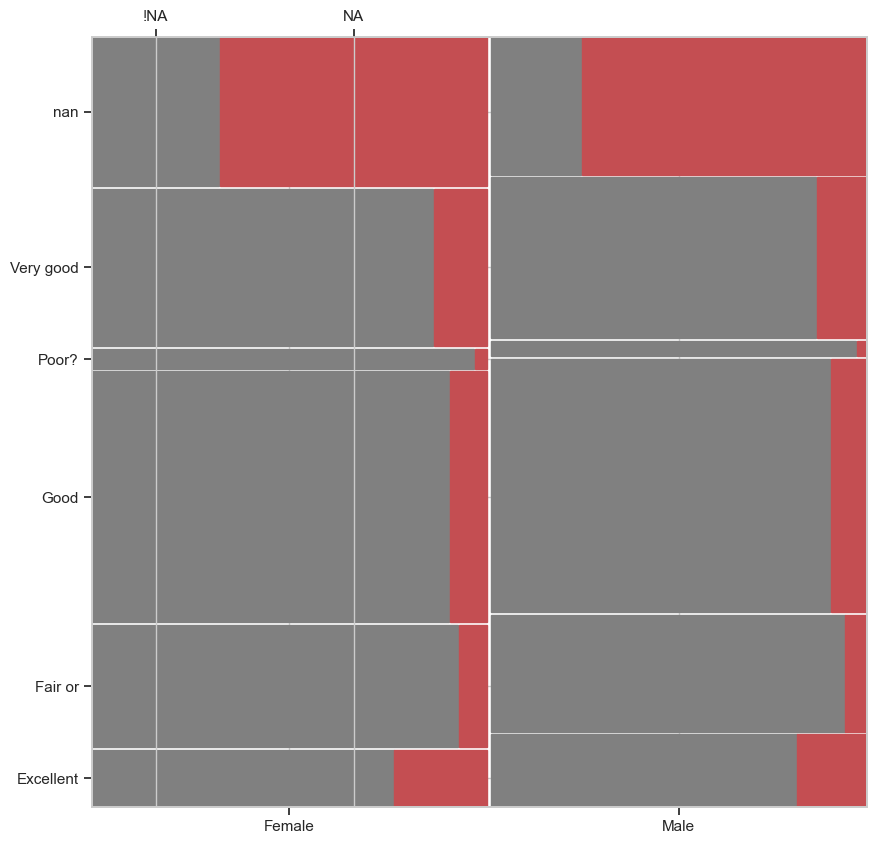

In [34]:
fig, ax = plt.subplots(figsize = (10,10))

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    # Reemplezando la informacion en la columna 'weight' por si hay null o no null
    .assign(
        weight = lambda df : df['weight'].isna().replace([True, False], ['NA', '!NA'])
    )
    # Cuantificar cuantas apariciones existe por cada combinaciòn de estas 3 columnas
    .groupby(
        ['gender', 'general_health_condition', 'weight'], 
        dropna = False, 
        as_index = True
    )
    .size()
    # Grafico de mosaicos, permite visualizar este tipo de relaciones en las cuales nosotros tenemos conteos de diferentes variables categoricas
    # Con diferentes subniveles 
    .pipe(
        lambda df : mosaic(
            data = df,
            properties = lambda key : {'color' : 'r' if 'NA' in key else 'gray'},
            horizontal = True,
            axes_label = True,
            title = '',
            labelizer = lambda key : '',
            ax = ax
        )
    )
);

In [36]:
def missing_mosaic_plot(
        self,
        target_var : str,
        x_categorical_var : str,
        y_categorical_var : str,
        ax = None
): 
    return(
        self._obj
        .assign(
            {target_var : lambda df : df['weight'].isna().replace([True, False], ['NA', '!NA'])}
        )
        .groupby(
            [x_categorical_var, y_categorical_var, target_var], dropna = False, as_index = True
        )
        .size()
        .pipe(
            lambda df : mosaic(
                data = df,
                properties = lambda key : {'color':'r' if 'NA' in key else 'gray'},
                ax = ax,
                horizontal = True,
                axes_label = True,
                tite = '',
                labelizer = lambda key : '',
            )
        )
    )

## Tratamiento de variables categóricas para imputación de valores faltantes

In [35]:
nhanes_transformed_df = nhanes_df.copy(deep=True)
nhanes_transformed_df

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...,...
7152,102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
7153,102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
7154,102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female
7155,102955.0,NaN,NaN,Very good,150.0,74.0,0,14.0,Female


### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>

    LabelEncoder
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [38]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [['Male'], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [39]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [41]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [42]:
encoder.inverse_transform([[1],[0], [1]])

array([['Male'],
       ['Female'],
       ['Male']], dtype=object)

### Aplicando la codificación ordinal a todas tus variables categóricas

In [44]:
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [46]:
# Función de sklearn que nos permite componer instrucciones de transformación de nuestros datos 
categorical_transformer = sklearn.compose.make_column_transformer(
    # Tupla, transformador que queremos hacer y los nombres de las columnas que queremos que se transformen en nuestro conjunto de datos 
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    # se ignoran las otras variables
    remainder = 'passthrough'
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [53]:
# Creando un nuevo DF
nhanes_transformed_df = (
    pd.DataFrame(
        # Ajustar nuestros datos y transformalos en un solo paso
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x : x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('remainder__')
    )
)

nhanes_transformed_df

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,NaN,NaN,150.0,74.0,0.0,14.0


In [54]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1)
)

(
    gender_encoder
    .fit_transform(
        X = gender_values
        )
        .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transformed_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])